<a href="https://colab.research.google.com/github/souvikjana1993/Mask_RCNN/blob/master/PROJ_DRAFT5_07_03withImage_Augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Mask R-CNN instance segmentation with custom dataset in Google Colab
Jupyter notebook providing steps to train a **Matterport Mask R-CNN** model with custom dataset.

It runs in [Google Colab](https://colab.research.google.com/) using [Matterport framework](https://github.com/matterport/Mask_RCNN) with TensorFlow backend.

**Requirements are only dataset images and annotations file.**

**Colab Runtime type: Python3, GPU enabled.**

#Making Dataset
I generated dataset annotations with [VGG Image Annotator](http://www.robots.ox.ac.uk/~vgg/software/via/).

Notebook train a model for one class object detection. It is possible to slightly modify notebook to train model for multiple classes.

Before running notebook, we need to create dataset:


1.   Collect various pictures of objects to detect
3.   Create annotation files in VGG
4.   Create image.zip file having structure defined below
5.   Upload the zip file in your Google Drive

Zip file structure:
```
images.zip
|- "train" directory
  |- jpg image files of training data
  |- "via_region_data.json" annotations file of training data
|- "val" directory
  |- jpg image files of validation data
  |- "via_region_data.json" annotations file of validation data
```
Check my image.zip file as dataset example.

#Install required packages

In [1]:
%cd
!git clone --quiet https://github.com/souvikjana1993/Mask_RCNN.git

/root


In [0]:
%cd ~/Mask_RCNN
!pip install -q PyDrive
!pip install -q -r requirements.txt
!python -q setup.py install

In [3]:
from google.colab import drive
drive.mount('/content/mydrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/mydrive


#Download and extract dataset


In [0]:
%cd ~/Mask_RCNN
import os
os.makedirs('dataset')
os.chdir('dataset')
!unzip '/content/mydrive/My Drive/dataset4.zip' 

#Edit settings file
*  find and replace occurrences of "balloon" and "Balloon" with name of your object
*  set epochs number


In [30]:
import shutil
shutil.move('/content/balloon.py','/root/Mask_RCNN/samples/balloon/balloon.py')

'/root/Mask_RCNN/samples/balloon/balloon.py'

In [31]:
%cd ~/Mask_RCNN


!cp ~/Mask_RCNN/samples/balloon/balloon.py ./armas.py

!sed -i -- 's/balloon/gun/g' armas.py
!sed -i -- 's/Balloon/Gun/g' armas.py
!sed -i -- 's/epochs=30/epochs=5/g' armas.py

/root/Mask_RCNN


#Train model
Pretrained weights options are COCO, ImageNet or a model trained before

In [32]:
%cd ~/Mask_RCNN

!python armas.py train --dataset=dataset/ --weights='coco'
#!python3 armas.py train --dataset=dataset/ --weights='/logs/gun20190306T1919/mask_rcnn_gun_0007.h5'

/root/Mask_RCNN
Using TensorFlow backend.
Weights:  coco
Dataset:  dataset/
Logs:  /logs

Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_

In [0]:
%cd ~/Mask_RCNN
os.getcwd()

/root/Mask_RCNN


'/root/Mask_RCNN'

In [35]:
import os
import cv2
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import skimage
import glob
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

import armas

# Root directory of the project
ROOT_DIR = os.getcwd()

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library

#custom_WEIGHTS_PATH = sorted(glob.glob("/logs/*/mask_rcnn_*.h5"))[-1]
custom_WEIGHTS_PATH ='/logs/gun20190307T1133/mask_rcnn_gun_0018.h5'

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

config = armas.GunConfig()
custom_DIR = os.path.join(ROOT_DIR, "dataset")

class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()

# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/gpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "inference"

def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax
  
# Load validation dataset
dataset = armas.GunDataset()
dataset.load_gun(custom_DIR, "val")

# Must call before using the dataset
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                              config=config)

# load the last model you trained
# weights_path = model.find_last()[1]

# Load weights
print("Loading weights ", custom_WEIGHTS_PATH)
model.load_weights(custom_WEIGHTS_PATH, by_name=True)

from importlib import reload # was constantly changin the visualization, so I decided to reload it instead of notebook
reload(visualize)

Using TensorFlow backend.



Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

<module 'mrcnn.visualize' from '/root/Mask_RCNN/mrcnn/visualize.py'>

# RESULTS ON DATASET

In [0]:
#image_id = random.choice(dataset.image_ids)
for image_id in dataset.image_ids:
  image, image_meta, gt_class_id, gt_bbox, gt_mask =\
      modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
  info = dataset.image_info[image_id]
  print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                         dataset.image_reference(image_id)))

  # Run object detection
  results = model.detect([image], verbose=1)

  # Display results
  ax = get_ax(1)
  r = results[0]
  visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                              dataset.class_names, r['scores'], ax=ax,
                              title="Predictions")
  log("gt_class_id", gt_class_id)
  log("gt_bbox", gt_bbox)
  log("gt_mask", gt_mask)

In [0]:
# from google.colab import files
# files.download('/root/Mask_RCNN/Mask_RCNN/logs/gun20190227T1851/mask_rcnn_gun_0007.h5')

In [0]:
# %cd ~/Mask_RCNN/Mask_RCNN
# !mkdir logs
# shutil.move('/root/Mask_RCNN/gun20190227T1851','/root/Mask_RCNN/Mask_RCNN/logs')

'/root/Mask_RCNN/Mask_RCNN/logs/gun20190227T1851'

In [0]:
#!zip -r /content/file.zip /content/Folder_To_Zip
!zip -r /root/Mask_RCNN/Mask_RCNN/logs.zip /content/logs.zip
#root/Mask_RCNN/Mask_RCNN

	zip warning: name not matched: /content/logs.zip

zip error: Nothing to do! (try: zip -r /root/Mask_RCNN/Mask_RCNN/logs.zip . -i /content/logs.zip)


In [0]:
 %cd ~/Mask_RCNN/samples
import os
os.makedirs('sample')
os.chdir('sample')
!wget https://sci2s.ugr.es/sites/default/files/files/TematicWebSites/WeaponsDetection/BasesDeDatos/WeaponS.zip
!wget https://sci2s.ugr.es/sites/default/files/files/TematicWebSites/WeaponsDetection/BasesDeDatos/Test.zip
!unzip '/root/Mask_RCNN/samples/sample/WeaponS.zip'
#!unzip '/root/Mask_RCNN/samples/sample/Test.zip'
IMAGE_DIR = '/root/Mask_RCNN/samples/sample/WeaponS'
#IMAGE_DIR = '/root/Mask_RCNN/samples/sample/Test'
class_names= ['BG', 'gun']


In [38]:
os.getcwd()

'/root/Mask_RCNN/samples/sample'

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  


Processing 1 images
image                    shape: (2340, 2634, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  148.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 2634.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


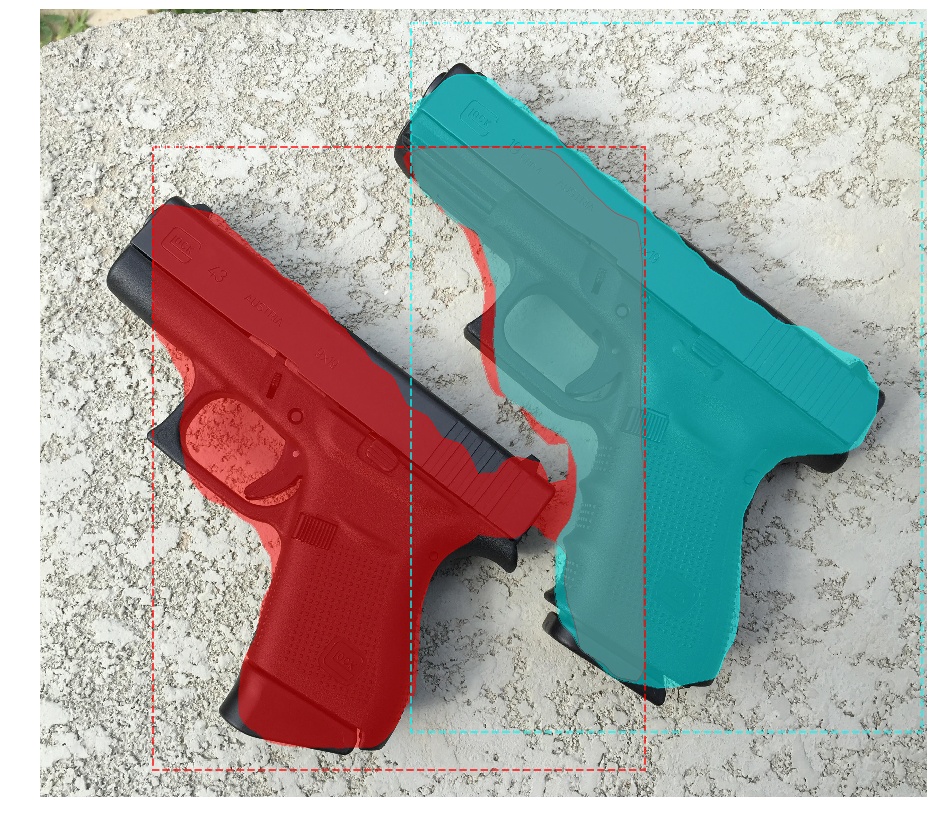

In [69]:
import random
from scipy import misc
##run object detection
# Load a random image from the images folder
file_names = next(os.walk(IMAGE_DIR))[2]
image = misc.imread(os.path.join(IMAGE_DIR, random.choice(file_names)))
# Run detection
results = model.detect([image], verbose=1)
# Visualize results
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], class_names, r['scores'])

In [0]:
# #Detect and color splash on a image with the last model you trained.
# #This will find the last trained weights in the model directory.
# python surgery.py splash --weights=last --image=/home/...../*.jpg

# #Detect and color splash on a video with a specific pre-trained weights of yours.
# python sugery.py splash --weights=/home/.../logs/mask_rcnn_surgery_0030.h5  --video=/home/simon/Videos/Center.wmv

In [0]:
from google.colab import drive
drive.mount('/content/mydrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/mydrive


In [34]:
import shutil
shutil.copy('/logs/gun20190307T1133/mask_rcnn_gun_0018.h5','/content/mydrive/My Drive')

'/content/mydrive/My Drive/mask_rcnn_gun_0018.h5'

# VISUALISING ANCHOR BOXES